<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Opt_Proyecto_derivative_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Idea general del algoritmo.

Input: 


*   $f:\mathbb{R}^n⟶ \mathbb{R}$, función objetivo.
*   $x_0$, aproximación inicial.
*   $a_{max}$, Número máximo de iteraciones para la busqueda en linea.
*   $\zeta$, parámetro de curvatura.
*   $tol_g$, criterio de paro para la norma del gradiente.



Descripción general del algoritmo (Ver Derivative-free optimization, pag 9.)

*   Calcular $f(x_0)$
*   Estimar $\epsilon_f$ usando ECnoise*
*   Calcular ** h
*   Calcular $\nabla_h f(x_0)$. Cuando se haga, guardar los valores $(x_s,f_s)$ que satisfacen $f_s=f(x_s)=min_{x\in S} f(x)$, $S=\{x+h\cdot e_i,i=1,\ldots,n\}$
*   While ($||\nabla f(x_k)||>tol_g$):
    *   Calcular $d_k=-H_k\nabla_h f(x_k)$ usando L-BFGS***
    *   Hacer line_search$(x_k,f_k,\nabla_h f(x_k),d_k,a_{max})$ y obtiene $(x_+,f_+,\alpha_k,LS_{flag})$
        *   If($LS_{flag}==1$):
            *   Invocar Recovery($x_s,f_s$)
        *   Else:
            *   Actualizar $x_{k+1}=x_+,$ $f_{k+1}=f_+$
    *   Calcular $\nabla_h f(x_{k+1})$ y guardar $(x_s,f_s)$
    *   Calcular $s_k=x_{k+1}-x_k$, $y_k=\nabla_h f(x_{k+1})-\nabla_h f(x_k)$
        *   Guardarlos si $s_k^Ty_k\geq \zeta||s_k||||y_k||$

Explicación de L-BFGS: (Ver clase en Moodle.)

Si $H_k$ es una aproximación de la inversa del Hessiano, nos interesa caluclar $d_k=-H_k\nabla f(x_k)$.


Input:



*   $\nabla f(x_k)$
*   $\{(s_{k-1},y_{k-1}),(s_{k-2},y_{k-2}),\ldots,(s_{k-m},y_{k-m})\}$
*   $H^0_{k-m}$

Algoritmo:


*   Define $q=\nabla f(x_k)$
*   for $i=1,2,\ldots,m$ do:
    *   Calcular $\alpha_i=\rho_i s_{k-i}^Tq$
    *   Actualiza $q=q-\alpha_iy_i$
*   Define $r=H^0_{k-m}q$
*   for $i=1,2,\ldots,m$ do:
    *   Calcular $\beta=\rho_{k-i}y_{k-i}^Tr$
    *   Actualiza $r=r-s_{k-i}(\alpha_i-\beta)$
*   $r$ es una aproximación de $H_k\nabla f(x_k)$


In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
def L_BFGS(S,Y,g):#Checar las posibles divisiones por cero
    n=len(g)
    m=len(S)
    #supondremos H_0 un multiplo de la identidad
    H_0=(np.dot(S[-1],Y[-1])/(np.dot(Y[-1],Y[-1])))*np.identity(n)#Dado en clase.
    q=g
    alphas=[]
    for i in range(m):
        alphas.append((1/max(10**(-6),np.dot(S[m-1-i],Y[m-1-i])))*np.dot(S[m-1-i],q))
        q=q-alphas[i]*Y[m-1-i]
    r=np.dot(H_0,q)
    for i in range(m):
        beta=(1/max(10**(-6),np.dot(Y[i],S[i])))*np.dot(Y[i],r)
        r=r+S[i]*(alphas[m-1-i]-beta)#aproximacion de -H*g
    return r

In [3]:
def ECNoise(F):#F es un vector que guarda f(t_i), i=0,...,m. Evaluaciones de m+1 puntos equiespaciados
#Ver metodo en Estimating_Computational_Noise, pagina 8
    m=len(F)-1
    T=np.zeros((m+1,m+1))
    for i in range(m+1):
        T[i,0]=F[i]
    for k in range(m):
        for i in range(m-k):
            T[i,k+1]=T[i+1,k]-T[i,k]
    return T

In [4]:
def var_estimation(T):#Recibe la tabla.
    m=len(T)-1
    sigma_array=[]
    for k in range(1,m):
        sigma_array.append(((np.math.factorial(k)/np.math.factorial(2*k))/(m+1-k))*np.sum(T.T[k]**2))
    #Ahora checamos las 2 condiciones.
    for k in range(1,m-2):
        max_k=np.max(sigma_array[k:k+2])
        min_k=np.min(sigma_array[k:k+2])
        if(max_k<=4*min_k):
            if(np.sign(min_k*max_k)==-1):
                print("es el ", k)
                break
    return np.sqrt(sigma_array[k])#Podria ser que las condiciones no se cumplan, en tal caso regresa la ultima estimacion sigma.

In [5]:
def aprox_f_biprima(e_f,f,x_k,p):#Usando una direccion (aleatoria dada) se aproxima el max ||Hessiana_f(x_k)*p||
    #Ver Estimating Derivatives of Noisy Simulations, pagina 14.
    tao_1=100
    tao_2=0.1
    h_a=e_f**(1/4)
    f_mas=f(x_k+h_a*p)
    f_menos=f(x_k-h_a*p)
    f_0=f(x_k)
    delta_h_a=abs(f_mas+f_menos-2*f_0)
    mu_a=delta_h_a/(np.max([h_a**2,10**(-6)] ))
    if(delta_h_a/e_f>=tao_1):
        mu=mu_a
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_a
    h_b=(e_f/mu_a)**(1/4)
    f_mas=f(x_k+h_b*p)
    f_menos=f(x_k-h_b*p)
    delta_h_b=abs(f_mas+f_menos-2*f_0)
    mu_b=delta_h_b/(np.max([h_b**2,10**(-6)] ))
    if(delta_h_b/e_f>=tao_1):
        mu=mu_b
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_b
    if(abs(mu_a-mu_b)<=0.5*mu_b):
        return mu_b
    #print("No hay regla de decision")
    return 1#Por falta de relga de descicion. En el algoritmo no se especifica una opcion.


In [6]:
def rutina_h(f,p,x_0,m=10):#Calcula h a partir de una direccion dada, con m+1 puntos equiespaciados.
    f_0=f(x_0)
    n=len(x_0)
    delta=10**(-3)#Suggested by ECnoise algorithm.
    F_st=[f(x_0+delta*i*p) for i in range(m)]
    T=ECNoise(F_st)
    e_f=var_estimation(T)
    #print("e_f: ",e_f)#Breakpoint
    mu=aprox_f_biprima(e_f=e_f,f=f,x_k=x_0,p=p)
    h=(8**(1/4))*(e_f/mu)**(1/2)
    return e_f,h

In [27]:
def Rosembrok(X):#X es un vector.
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2))#+10**(-3)*np.random.uniform(0,1))#Ruido
def Rosembrok_r(X):#X es un vector.
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2)+10**(-3)*np.random.uniform(0,1))#Ruido
def Rosembrok_grad(X):
    return scipy.optimize.approx_fprime(f=Rosembrok,xk=X,epsilon=10**(-4))
def Rosembrok_grad_real(X):
    D=[]
    D.append(-400*(X[0]*(X[1]-X[0]**2))-2*(1-X[0]))
    for i in range(1,len(X)-1):
        D.append(-400*(X[i]*(X[i+1]-X[i]**2))+200*(X[i]-X[i-1]**2)-2*(1-X[i]))
    D.append(200*(X[-1]-X[-2]**2))
    return np.array(D)
def Rosembrok_Hessian(X):
    M=[]
    #Renglon 1
    D=np.zeros(len(X))
    D[0]=(-400*(X[1]-X[0]**2)+800*(X[0]**2)+2)
    D[1]=-400*(X[1])
    M.append(D)
    #Renglon 2<i<n
    for i in range(1,len(X)-1):
        D=np.zeros(len(X))
        D[i]=(-400*(X[i+1]-X[i]**2)+800*(X[i]**2)+202)
        D[i-1]=-400*X[i-1]
        D[i+1]=-400*X[i]
        M.append(D)
    #Renglon n
    D=np.zeros(len(X))
    D[-2]=-400*X[-2]
    D[-1]=200
    M.append(D)
    return M

In [8]:
#Muestra de la estimacion del gradiente con Forward difference.
n=10
x_k=np.random.uniform(0,1,size=n)
p=np.eye(1,len(x_k),np.random.randint(0,len(x_k)))
e_f,h=rutina_h(f=Rosembrok_r,p=p,m=6,x_0=x_k)
print(h)
print(scipy.optimize.approx_fprime(f=Rosembrok,xk=x_k,epsilon=h))
print(Rosembrok_grad_real(x_k))
#------------------------------------------------------

0.020978151978140364
[ -32.67806243   54.54034848  -39.11330359  247.33379321   36.98935477
 -112.48343093   90.01841439   16.77156359  -53.22812443  103.81255969]
[-33.074717280889274, 51.01133426492996, -37.14005555067933, 236.454912497252, 27.75817477503413, -116.47269350297897, 82.98306245503565, 11.967943425720675, -53.42861398792345, 101.71474448938172]


In [57]:
def relaxed_Armijo(x_k,f,fprime,d,alpha_0=1,e_f=0.0,c_1=0.1,c_2=0.9,
                   max_iter=10**2):##Intenté usar scipy.line_search(), pero Strong Wolfe son dificiles de satisfacerse
    #Metodo visto en clase.
    iter=0
    alpha=0
    grad_f_k=fprime(x_k)
    f_k=f(x_k)
    beta=np.inf
    alpha_i=alpha_0
    g_dot_d=np.dot(grad_f_k,d)
    for i in range(max_iter):
        if(f(x_k+alpha_i*d)>f_k+c_1*alpha_i*g_dot_d+2*e_f):#Aqui esta la condicion relajada, dado e_f estimacion del error estandar.
            beta=alpha_i
            alpha_i=0.5*(alpha+beta)
        else:
            if(np.dot(fprime(x_k+alpha_i*d),d)<c_2*g_dot_d):
                alpha=alpha_i
                if(beta==np.inf):
                    alpha_i*=2*alpha
                else:
                    alpha_i=0.5*(alpha+beta)
            else:
                break
    return alpha_i
def backtrack(x_k, f, grad, d_k,
              c1=0.1, c2=0.9, alpha_0=1.0, maxIter=50):
    
    alpha    = 0.0
    beta     = np.inf
    alpha_k  = alpha_0
    
    f_k      = f(x_k)
    g_k      = grad(x_k)
    
    for k in range(1,maxIter+1):
        g_dot_d = np.dot(g_k,d_k)
        
        if f(x_k + alpha_k*d_k) > f_k + c1*alpha_k*g_dot_d:
            beta     = alpha_k
            alpha_k  = 0.5*(alpha + beta)
        elif np.dot( grad( x_k+alpha_k*d_k), d_k ) < c2*g_dot_d:
            alpha = alpha_k
            if beta == np.inf:
                alpha_k *= 2.0*alpha
            else:
                alpha_k = 0.5*(alpha + beta)
        else:
            break
    
    return alpha_k



In [11]:
def recovery(x_k,f,grad_k,e_f,h,l1,l2,d_k,m=10):#Genera un nuevo h
    e_f_b,h_b=rutina_h(f=f,p=d_k,m=m,x_0=x_k)
    n=len(x_k)
    f_k=f(x_k)
    if(h_b<l1*h or h_b>l2*h):
        return x_k,e_f_b,h_b
    else:
        d_k=d_k/np.linalg.norm(d_k)
        x_h=x_k+h*(d_k)
        f_h=f(x_h)
        if(f_h<=f(x_k)+0.1*h*np.dot(grad_k,d_k)+2*e_f):
            return x_h,e_f,h
        else:
            f_stencil=[f(x_k+h*np.eye(1,n,i)) for i in range(n)]
            x_s=x_k+h*np.eye(1,n,np.argmin(f_stencil))
            f_s=f(x_s)
            if(f_h<=f_s and f_h<=f_k):
                return x_k,e_f,h
            else:
                if(f_k>f_s and f_h>f_s):
                    return x_s,e_f,h
                else:
                    e_f_n,h_n=rutina_h(f=f,p=np.random.uniform(-1,1,size=n),m=m,x_0=x_k)
                    return x_k,e_f_n,h_n

In [70]:
def find_minimum(f,fprime,x_0,tol_g=10**(-4),max_iter=10**2,alpha_max_iter=100):
    t1 = time.time()
    n=len(x_0)
    #----------------------
    #Listas
    iter=0
    GG=[]
    Y=[]
    S=[]
    #----------------------
    #----------------------
    #e_f,h=rutina_h(f=f,p=np.random.uniform(-1,1,size=len(x_0)),m=10,x_0=x_0)
    #print("h: ",h)
    e_f=0
    h=10**(-4)
    g_0=fprime(x_0)#Gradiente
    alpha_k=relaxed_Armijo(f=f,fprime=fprime,x_k=x_0,d=-g_0,e_f=e_f,max_iter=alpha_max_iter)#line_search
    #alpha_k=backtrack(x_k=x_0, f=f, grad=fprime, d_k=-g_0)
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=fprime(x_1)
    GG.append(np.linalg.norm(g_1))
    #----------------------
    #diferencia de gradientes
    #diferencia de x's
    Y.append(g_1-g_0)
    S.append(-alpha_k*g_0)
    #comp=[np.linalg.norm(d_k_r+g_0)]#Lista para compararlos
    #H_k=(np.dot(s_k,y_k)/(np.dot(y_k,y_k)))*np.identity(n)#Dado en clase.
    #----------------------
    while(np.linalg.norm(g_1)>tol_g and iter<max_iter):
        x_0=x_1
        g_0=g_1
        #H_k_m=BFGS(s_k=s_k,y_k=y_k,g_k=0,H_k=H_k)
        #d_k=-np.dot(np.linalg.inv(Rosembrok_Hessian(x_0)),g_0)
        d_k=-L_BFGS(S=S,Y=Y,g=g_1)
        #d_k=-np.dot(H_k_m,g_0)
        if(iter>100):
            del S[0]
            del Y[0]
        iter_alpha=0
        alpha_k_try=0
        while(alpha_k_try==0 and iter_alpha<1):
            alpha_k_try=relaxed_Armijo(f=f,fprime=fprime,x_k=x_0,d=d_k,e_f=e_f,max_iter=50)#line_search
            #alpha_k_try=backtrack(x_k=x_0, f=f, grad=fprime, d_k=d_k)
            if(alpha_k_try>0):
                alpha_k=alpha_k_try
                break
            else:
                print("Err")
                #x_k,e_f,h=recovery(x_k=x_0,f=f,grad_k=g_0,e_f=e_f,h=h,l1=0.4,l2=2.5,d_k=d_k)
                #print("Cambiamos h! :")
                #def fprime(x):
                #    return scipy.optimize.approx_fprime(xk=x,f=f,epsilon=h)
                iter_alpha+=1
        x_1=x_0+alpha_k*d_k#
        g_1=fprime(x_1)
        iter+=1
        #H_k=H_k_m
        Y.append(g_1-g_0)
        S.append(alpha_k*d_k)
        #print(np.linalg.norm(d_k-d_k_l))
        GG.append(np.linalg.norm(g_1))
    print("Summary: ")
    
    #print("comp:",comp[-1])
    plt.plot(GG)
    plt.show()
    t2 = time.time()
    tim = t2-t1
    niter = iter
    print("time: {:.02e}\t Niter: {} \t ||g_k||: {:.02e} ".format(
             tim,niter,GG[-1]))
    return x_1

[0.87454012 1.45071431 1.23199394 1.09865848 0.65601864 0.65599452
 0.55808361 1.36617615 1.10111501 1.20807258]
Summary: 


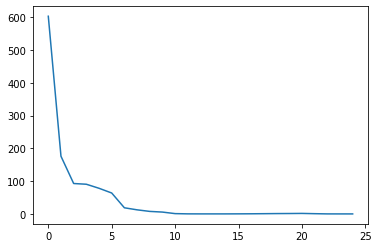

time: 3.19e-01	 Niter: 24 	 ||g_k||: 7.71e-03 
[0.99999792 0.99999883 1.00000227 1.         1.0000035  1.00000719
 1.00000692 1.00001529 1.00003138 1.00007541]


In [76]:
import time
np.random.seed()
n=10
x_0=np.random.uniform(0.5,1.5,size=n)
print(x_0)
x_opt=find_minimum(f=Rosembrok,fprime=Rosembrok_grad_real,x_0=x_0,tol_g=10**(-2),max_iter=10**4,alpha_max_iter=20)
print(x_opt)

In [ ]:
def p_204(X):#x_0=np.array([0.1,0.1] ), x_opt=np.array([0,0] )
    A=np.array([0.13294 ,-0.244378, 0.325895] )
    D=np.array([2.5074 ,-1.36401,1.02282] )
    H=np.array([[-0.564255 ,0.392417], [ -0.404979, 0.927589], [-0.0735084 ,0.535493]] )
    B=np.linalg.inv(np.dot(H.T,H))
    W=A+np.dot(H,X)+0.5*np.dot(X,np.dot(B,X))*D
    return np.dot(W,W)+np.random.uniform(-10**(-2),10**(-2))
p_204([1,1])

413.6606209623544

In [ ]:
n=2
x_0=np.array([0.1,0.1] )
eps=10**(-2)
#def f_1(x):
#    return f_noise(f=p_205,x=x,eps=eps,noise='additive')
x_opt=find_minimum(f=p_204,x_0=x_0,tol_g=10**(-2),max_iter=2*10**4,alpha_max_iter=10)

No hay regla de decision
h:  0.013175081310817176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: ignored

In [ ]:
def p_205(X):#x_0=np.array([0.1,0.] ), x_opt=np.array([3,0.5] )
    return ((1.5-X[0]*(1-X[1]))**2+(2.25-X[0]*(1-X[1]**2))**2+(2.625-X[0]*(1-X[1]**3))**2)
print(p_205([1,1]))

14.203125


In [ ]:
def p_206(X):#x_0=[-1.2,1], x_opt=[1,1]
    return ((X[1]-X[0]**2)**2+100*(1-X[0])**2)
print(p_206([-1.2,1]))

484.19360000000006


In [ ]:
def p_212(X):#x_0=[2,0], x_opt=[0,0]
    return (((4*(X[0]+X[1]))**2+(4*(X[0]+X[1])+(X[0]-X[1])*((X[0]-2)**2+X[1]**2-1))**2))
print(p_212([0,0]))

0


In [ ]:
def p_214(X):#x_0=[-1.2,1], x_opt=[1,1]
    return ((10*(X[0]-X[1])**2+(X[0]-1)**2)**(1/4))

In [ ]:
def additive_noise(f,x,eps=10**(-2),label='stochastic'):
    if(label=='deterministic'):
        u=10**(-2)##por definirse
    if(label=='stochastic'):
        u=np.random.uniform(-eps,eps)
    return(f(x)+u)
def multiplicative_noise(f,x,eps=10**(-2),label='stochastic'):
    if(label=='deterministic'):
        u=10**(-2)##por definirse
    if(label=='stochastic'):
        u=np.random.uniform(-eps,eps)
    return(f(x)*(1+u))

In [ ]:
def f_noise(f,x,eps,noise):
        if(noise=='additive'):
            return additive_noise(f=f,eps=eps,x=x)
        if(noise=='multiplicative'):
            return multiplicative_noise(f=f,eps=eps,x=x)
        if(noise=='additive_det'):
            return additive_noise(f=f,eps=eps,x=x,label='deterministic')
        if(noise=='multiplicative_det'):
            return multiplicative_noise(f=f,eps=eps,x=x,label='deterministic')

In [ ]:
funciones=[p_204,p_205,p_206,p_212,p_214]
x_initial=[np.array([0.1,0.1] ),np.array([0.1,0.] ),[-1.2,1],[2,0],[-1.2,1]]
noise_type=['additive']
eps=10**(-2)
n=5
for i in range(len(funciones)):
    f=funciones[i]
    x_0=x_initial[i]
    for noise in noise_type:
        def f_1(x):
            return f_noise(f=f,x=x,noise=noise)
        x_opt=find_minimum(f=f_1,x_0=x_0,tol_g=10**(-2),max_iter=2*10**4,alpha_max_iter=10)